In [35]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
)
from sklearn.preprocessing import (
    RobustScaler,
    OneHotEncoder,
    TargetEncoder,
)
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    r2_score,
    mean_absolute_error,
)
import scipy as sp

from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression

import time
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
import re

from common import (
    CustomOneHotEncoder,
    apply_onehot_encoder,
    apply_custom_encoder,
    compare_pipelines,
    grid_search,
    get_linear_regression_scores,
    build_pipeline,
    plot_predictions,
    split,
)

In [36]:
pd.set_option("display.max_colwidth", None)

In [37]:
data = pd.read_csv("clean_data.csv")
data.drop(columns="Unnamed: 0", inplace=True)
data

,PrimaryPropertyType,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,...,ElectricityUse(Percentage),SteamUse(Percentage),NaturalGasUse(Percentage),LargestUseTypeGFA(Percentage),SecondLargestUseTypeGFA(Percentage),ThirdLargestUseTypeGFA(Percentage),ParkingGFA(Percentage),NumberOfYearsENERGYSTARCertified,BuildingAge,NumberOfPropertyUses
0,Leisure,47.61220,-122.33799,0.30103,1.113943,4.946624,Leisure,None,None,60.0,...,54.61,27.73,17.66,100.00,0.00,0.00,0.00,0.0,89,1
1,Leisure,47.61317,-122.33393,0.30103,1.079181,5.015221,Leisure,ServiceFacility,Leisure,61.0,...,38.66,0.00,61.34,80.99,14.55,4.46,14.55,0.0,20,3
2,Leisure,47.61393,-122.33810,0.30103,1.623249,5.980508,Leisure,None,None,43.0,...,68.23,29.71,2.06,79.12,0.00,0.00,20.57,0.0,47,1
3,Leisure,47.61412,-122.33664,0.30103,1.041393,4.787609,Leisure,None,None,56.0,...,40.75,32.59,26.66,100.00,0.00,0.00,0.00,0.0,90,1
4,Leisure,47.61375,-122.34047,0.30103,1.278754,5.244478,Leisure,ServiceFacility,Leisure,75.0,...,37.88,0.00,62.12,70.31,38.73,0.00,35.31,0.0,36,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,ServiceFacility,47.54067,-122.37441,0.30103,0.301030,4.261548,Leisure,None,None,NaN,...,67.84,0.00,32.16,100.00,0.00,0.00,0.00,0.0,34,1
1533,ServiceFacility,47.59625,-122.32283,0.30103,0.301030,4.204147,Leisure,None,None,NaN,...,41.73,0.00,58.27,100.00,0.00,0.00,0.00,0.0,12,1
1534,ServiceFacility,47.63644,-122.35784,0.30103,0.301030,4.119190,Leisure,ServiceFacility,Leisure,NaN,...,31.08,0.00,68.92,57.63,42.37,0.00,0.00,0.0,42,3
1535,ServiceFacility,47.52832,-122.32431,0.30103,0.301030,4.149281,Leisure,ServiceFacility,School,NaN,...,48.49,0.00,51.51,46.81,46.10,3.43,0.00,0.0,27,5


We will set aside a data set that contains energy star score information

In [38]:
energy_data = data.copy()
energy_data = energy_data.loc[~energy_data["ENERGYSTARScore"].isna()]

# Separation of training and test data

In [39]:
y_emissions = data["TotalGHGEmissions"]
X = data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
        "NumberOfYearsENERGYSTARCertified",
        "ENERGYSTARScore",
    ],
    axis=1,
)

# Pipelines 

In [40]:
(X_train, X_test, y_train, y_test) = split(X, y_emissions)

Getting a baseline measure with OneHotEncoder

In [41]:
X_train_one_hot, X_test_one_hot = apply_onehot_encoder(X_train, X_test, data)

get_linear_regression_scores(X_train_one_hot, y_train, X_test_one_hot, y_test)

Train R2 score:  0.7453077814802394


Train RMSE score:  0.3090145650999951
Test R2 score:  0.5481689678168384
Test RMSE score:  0.41626822263849417


Getting a baseline measure with a custom encoder that condenses all property use types to 6 features representing the categories

In [42]:
X_train_custom_encoder, X_test_custom_encoder = apply_custom_encoder(
    X_train, X_test, data
)

get_linear_regression_scores(
    X_train_custom_encoder, y_train, X_test_custom_encoder, y_test
)

Train R2 score:  0.7324055207241674
Train RMSE score:  0.31661128187749377
Test R2 score:  0.5789213462711063
Test RMSE score:  0.40459446614080524


The train results with OneHotEncoder are slightly better but the test scores are better using the custom encoder

### Testing pipelines

Defining the different possible preprocessing operations

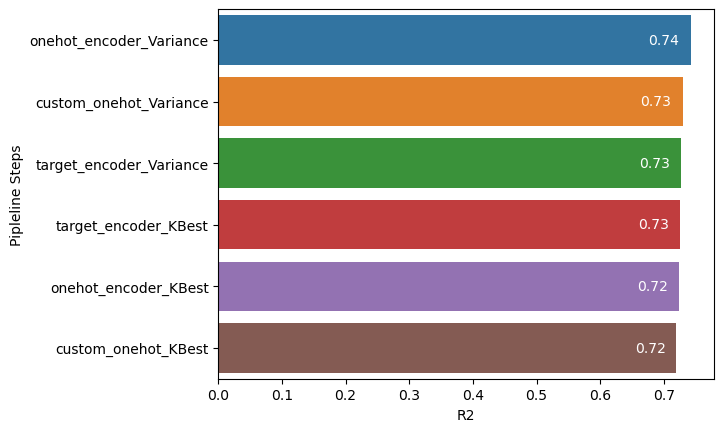

In [43]:
compare_pipelines(X_train, y_train, LinearRegression())

The pipeline that uses the custom OneHotEncoder, and the Variance feature selection yields the best R2 score on a LinearRegression model. However, the feature selection algorithms could yield better results with different hyperparameters. We will therefore use GridSearchCV to help selecting the best values

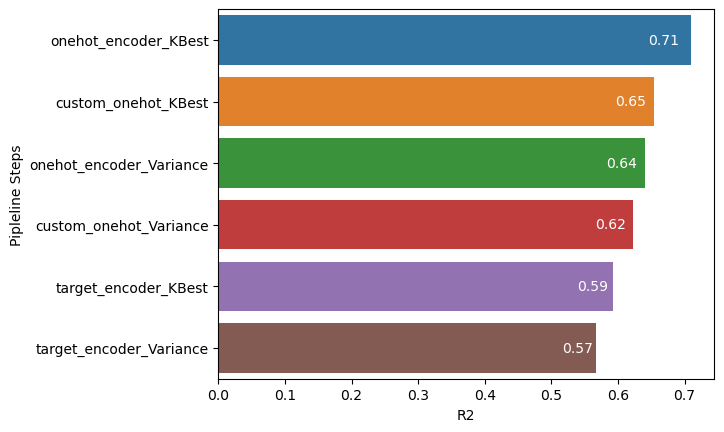

In [44]:
compare_pipelines(X_train, y_train, SVR())

Using SVR, the best score is achieved with OneHotEncoder and the SelectKBest feature selector.

We will test out these selectors with different hyperparameters across different models to see if we can obtain higher scores.

## Comparing metrics 

While MAE is less impacted by outliers, we will favor RMSE since this metric is stricter with large errors.

## Identifying optimal parameters with GridSearchCV

We will compare two pipelines, one using SelectKBest and one with Variance Threshold

In [45]:
model_comparison = pd.DataFrame()

In [46]:
kbest_params = {
    "selectkbest__k": [5, 7, 8, 10, "all"],
    "selectkbest__score_func": [f_regression],
}

variance_params = {"variancethreshold__threshold": [0.1, 0.3, 0.5, 0.7, 0.9]}

### Linear Regression

In [47]:
def linear_regression_grid_search(additional_params=None, selector=None):
    param_grid = {}
    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X,
        y_emissions,
        LinearRegression(),
        param_grid,
        model_comparison,
        selector,
    )


model_comparison = linear_regression_grid_search()

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3203,0.75,0.2359,0.309,{},0.81,4.65


In [48]:
model_comparison = linear_regression_grid_search(kbest_params, SelectKBest())

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3203,0.75,0.2359,0.3090,{},0.81,4.65
1,LinearRegression(),SelectKBest(),0.3855,0.72,0.2451,0.3213,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.17,4.41


In [49]:
model_comparison = linear_regression_grid_search(
    variance_params, VarianceThreshold())

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3203,0.75,0.2359,0.3090,{},0.81,4.65
1,LinearRegression(),SelectKBest(),0.3855,0.72,0.2451,0.3213,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.17,4.41
2,LinearRegression(),VarianceThreshold(),0.5770,0.37,0.3770,0.4865,{'variancethreshold__threshold': 0.9},0.03,0.90


### SVR

#### Without selector

In [50]:
def svr_grid_search(additional_params=None, selector=None):
    param_grid = {
        "svr__C": [1, 3, 5, 100],
        "svr__epsilon": [1e-2, 0.5, 1, 2, 5, 10],
    }
    if additional_params:
        param_grid.update(additional_params)

    return grid_search(X, y_emissions, SVR(), param_grid, model_comparison, selector)


model_comparison = svr_grid_search()

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3203,0.75,0.2359,0.3090,{},0.81,4.65
1,LinearRegression(),SelectKBest(),0.3855,0.72,0.2451,0.3213,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.17,4.41
2,LinearRegression(),VarianceThreshold(),0.5770,0.37,0.3770,0.4865,{'variancethreshold__threshold': 0.9},0.03,0.90
3,SVR(),None,0.6833,0.22,0.4188,0.5433,"{'svr__C': 1, 'svr__epsilon': 2}",0.03,4.43


#### With SelectKBest Selector

In [51]:
model_comparison = svr_grid_search(kbest_params, SelectKBest())

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3203,0.75,0.2359,0.3090,{},0.81,4.65
1,LinearRegression(),SelectKBest(),0.3855,0.72,0.2451,0.3213,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.17,4.41
2,LinearRegression(),VarianceThreshold(),0.5770,0.37,0.3770,0.4865,{'variancethreshold__threshold': 0.9},0.03,0.90
3,SVR(),None,0.6833,0.22,0.4188,0.5433,"{'svr__C': 1, 'svr__epsilon': 2}",0.03,4.43
4,SVR(),SelectKBest(),0.6833,0.26,0.4027,0.5290,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>, 'svr__C': 1, 'svr__epsilon': 2}",0.03,25.33


#### With Variance Threshold Selector

In [52]:
model_comparison = svr_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3203,0.75,0.2359,0.3090,{},0.81,4.65
1,LinearRegression(),SelectKBest(),0.3855,0.72,0.2451,0.3213,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.17,4.41
2,LinearRegression(),VarianceThreshold(),0.5770,0.37,0.3770,0.4865,{'variancethreshold__threshold': 0.9},0.03,0.90
3,SVR(),None,0.6833,0.22,0.4188,0.5433,"{'svr__C': 1, 'svr__epsilon': 2}",0.03,4.43
4,SVR(),SelectKBest(),0.6833,0.26,0.4027,0.5290,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>, 'svr__C': 1, 'svr__epsilon': 2}",0.03,25.33
5,SVR(),VarianceThreshold(),0.6833,0.07,0.4674,0.5906,"{'svr__C': 1, 'svr__epsilon': 2, 'variancethreshold__threshold': 0.1}",0.02,18.59


### ElasticNet

#### Without selector

In [53]:
def elastic_grid_search(additional_params=None, selector=None):
    param_grid = {
        "elasticnet__alpha": [1, 10, 15, 20],
        "elasticnet__l1_ratio": [1e-2, 1e-1, 0.3, 0.5, 0.8, 1],
        "elasticnet__max_iter": [3000],
        "elasticnet__random_state": [42],
    }
    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X, y_emissions, ElasticNet(), param_grid, model_comparison, selector
    )


model_comparison = elastic_grid_search()

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3203,0.75,0.2359,0.3090,{},0.81,4.65
1,LinearRegression(),SelectKBest(),0.3855,0.72,0.2451,0.3213,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.17,4.41
2,LinearRegression(),VarianceThreshold(),0.5770,0.37,0.3770,0.4865,{'variancethreshold__threshold': 0.9},0.03,0.90
6,ElasticNet(),None,0.6321,0.05,0.4753,0.5980,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.04,5.75
3,SVR(),None,0.6833,0.22,0.4188,0.5433,"{'svr__C': 1, 'svr__epsilon': 2}",0.03,4.43
4,SVR(),SelectKBest(),0.6833,0.26,0.4027,0.5290,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>, 'svr__C': 1, 'svr__epsilon': 2}",0.03,25.33
5,SVR(),VarianceThreshold(),0.6833,0.07,0.4674,0.5906,"{'svr__C': 1, 'svr__epsilon': 2, 'variancethreshold__threshold': 0.1}",0.02,18.59


#### With SelectKBest selector

In [54]:
model_comparison = elastic_grid_search(
    kbest_params,
    SelectKBest(),
)

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3203,0.75,0.2359,0.3090,{},0.81,4.65
1,LinearRegression(),SelectKBest(),0.3855,0.72,0.2451,0.3213,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.17,4.41
2,LinearRegression(),VarianceThreshold(),0.5770,0.37,0.3770,0.4865,{'variancethreshold__threshold': 0.9},0.03,0.90
3,ElasticNet(),None,0.6321,0.05,0.4753,0.5980,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.04,5.75
7,ElasticNet(),SelectKBest(),0.6321,0.04,0.4783,0.6019,"{'elasticnet__alpha': 1, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.01,10.03
4,SVR(),None,0.6833,0.22,0.4188,0.5433,"{'svr__C': 1, 'svr__epsilon': 2}",0.03,4.43
5,SVR(),SelectKBest(),0.6833,0.26,0.4027,0.5290,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>, 'svr__C': 1, 'svr__epsilon': 2}",0.03,25.33
6,SVR(),VarianceThreshold(),0.6833,0.07,0.4674,0.5906,"{'svr__C': 1, 'svr__epsilon': 2, 'variancethreshold__threshold': 0.1}",0.02,18.59


#### With VarianceThreshold selector

In [55]:
model_comparison = elastic_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3203,0.75,0.2359,0.3090,{},0.81,4.65
1,LinearRegression(),SelectKBest(),0.3855,0.72,0.2451,0.3213,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.17,4.41
2,LinearRegression(),VarianceThreshold(),0.5770,0.37,0.3770,0.4865,{'variancethreshold__threshold': 0.9},0.03,0.90
3,ElasticNet(),None,0.6321,0.05,0.4753,0.5980,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.04,5.75
4,ElasticNet(),SelectKBest(),0.6321,0.04,0.4783,0.6019,"{'elasticnet__alpha': 1, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.01,10.03
8,ElasticNet(),VarianceThreshold(),0.6321,0.04,0.4789,0.6018,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,8.23
5,SVR(),None,0.6833,0.22,0.4188,0.5433,"{'svr__C': 1, 'svr__epsilon': 2}",0.03,4.43
6,SVR(),SelectKBest(),0.6833,0.26,0.4027,0.5290,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>, 'svr__C': 1, 'svr__epsilon': 2}",0.03,25.33
7,SVR(),VarianceThreshold(),0.6833,0.07,0.4674,0.5906,"{'svr__C': 1, 'svr__epsilon': 2, 'variancethreshold__threshold': 0.1}",0.02,18.59


### RandomForest

#### Without selector

In [56]:
def random_forest_grid_search(additional_params=None, selector=None):
    param_grid = {
        "randomforestregressor__n_estimators": [50, 70, 100, 120],
        "randomforestregressor__min_samples_split": [2, 4, 6, 8],
        "randomforestregressor__max_features": ["sqrt", "log2", 1.0],
        "randomforestregressor__criterion": [
            "squared_error",
            "friedman_mse",
            "poisson",
        ],
        "randomforestregressor__random_state": [42],
    }

    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X,
        y_emissions,
        RandomForestRegressor(),
        param_grid,
        model_comparison,
        selector,
    )


model_comparison = random_forest_grid_search()

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3203,0.75,0.2359,0.3090,{},0.81,4.65
9,RandomForestRegressor(),None,0.3604,0.73,0.2437,0.3163,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 8, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,148.96
1,LinearRegression(),SelectKBest(),0.3855,0.72,0.2451,0.3213,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.17,4.41
2,LinearRegression(),VarianceThreshold(),0.5770,0.37,0.3770,0.4865,{'variancethreshold__threshold': 0.9},0.03,0.90
3,ElasticNet(),None,0.6321,0.05,0.4753,0.5980,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.04,5.75
4,ElasticNet(),SelectKBest(),0.6321,0.04,0.4783,0.6019,"{'elasticnet__alpha': 1, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.01,10.03
5,ElasticNet(),VarianceThreshold(),0.6321,0.04,0.4789,0.6018,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,8.23
6,SVR(),None,0.6833,0.22,0.4188,0.5433,"{'svr__C': 1, 'svr__epsilon': 2}",0.03,4.43
7,SVR(),SelectKBest(),0.6833,0.26,0.4027,0.5290,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>, 'svr__C': 1, 'svr__epsilon': 2}",0.03,25.33
8,SVR(),VarianceThreshold(),0.6833,0.07,0.4674,0.5906,"{'svr__C': 1, 'svr__epsilon': 2, 'variancethreshold__threshold': 0.1}",0.02,18.59


#### With SelectKBest selector

In [57]:
model_comparison = random_forest_grid_search(
    kbest_params,
    SelectKBest(),
)

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3203,0.75,0.2359,0.3090,{},0.81,4.65
10,RandomForestRegressor(),SelectKBest(),0.3466,0.72,0.2488,0.3223,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'selectkbest__k': 7, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.32,1214.63
1,RandomForestRegressor(),None,0.3604,0.73,0.2437,0.3163,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 8, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,148.96
2,LinearRegression(),SelectKBest(),0.3855,0.72,0.2451,0.3213,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.17,4.41
3,LinearRegression(),VarianceThreshold(),0.5770,0.37,0.3770,0.4865,{'variancethreshold__threshold': 0.9},0.03,0.90
4,ElasticNet(),None,0.6321,0.05,0.4753,0.5980,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.04,5.75
5,ElasticNet(),SelectKBest(),0.6321,0.04,0.4783,0.6019,"{'elasticnet__alpha': 1, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.01,10.03
6,ElasticNet(),VarianceThreshold(),0.6321,0.04,0.4789,0.6018,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,8.23
7,SVR(),None,0.6833,0.22,0.4188,0.5433,"{'svr__C': 1, 'svr__epsilon': 2}",0.03,4.43
8,SVR(),SelectKBest(),0.6833,0.26,0.4027,0.5290,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>, 'svr__C': 1, 'svr__epsilon': 2}",0.03,25.33


#### With VarianceThreshold selector

In [58]:
model_comparison = random_forest_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3203,0.75,0.2359,0.3090,{},0.81,4.65
1,RandomForestRegressor(),SelectKBest(),0.3466,0.72,0.2488,0.3223,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'selectkbest__k': 7, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.32,1214.63
2,RandomForestRegressor(),None,0.3604,0.73,0.2437,0.3163,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 8, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,148.96
3,LinearRegression(),SelectKBest(),0.3855,0.72,0.2451,0.3213,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.17,4.41
4,LinearRegression(),VarianceThreshold(),0.5770,0.37,0.3770,0.4865,{'variancethreshold__threshold': 0.9},0.03,0.90
5,ElasticNet(),None,0.6321,0.05,0.4753,0.5980,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.04,5.75
6,ElasticNet(),SelectKBest(),0.6321,0.04,0.4783,0.6019,"{'elasticnet__alpha': 1, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.01,10.03
7,ElasticNet(),VarianceThreshold(),0.6321,0.04,0.4789,0.6018,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,8.23
11,RandomForestRegressor(),VarianceThreshold(),0.6649,0.31,0.3924,0.5105,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'variancethreshold__threshold': 0.9}",0.14,533.68
8,SVR(),None,0.6833,0.22,0.4188,0.5433,"{'svr__C': 1, 'svr__epsilon': 2}",0.03,4.43


### Gradient Boosting

#### Without Selector

In [59]:
def gradient_boosting_grid_search(additional_params=None, selector=None):
    param_grid = {
        "gradientboostingregressor__n_estimators": [120, 150, 200],
        "gradientboostingregressor__loss": [
            "squared_error",
            "absolute_error",
            "huber",
        ],
        "gradientboostingregressor__min_samples_split": [6, 8, 10],
        "gradientboostingregressor__max_features": ["sqrt", "log2", 1.0],
        "gradientboostingregressor__random_state": [42],
    }

    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X,
        y_emissions,
        GradientBoostingRegressor(),
        param_grid,
        model_comparison,
        selector,
    )


model_comparison = gradient_boosting_grid_search()

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3203,0.75,0.2359,0.3090,{},0.81,4.65
12,GradientBoostingRegressor(),None,0.3425,0.75,0.2369,0.3065,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42}",0.27,109.32
1,RandomForestRegressor(),SelectKBest(),0.3466,0.72,0.2488,0.3223,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'selectkbest__k': 7, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.32,1214.63
2,RandomForestRegressor(),None,0.3604,0.73,0.2437,0.3163,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 8, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,148.96
3,LinearRegression(),SelectKBest(),0.3855,0.72,0.2451,0.3213,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.17,4.41
4,LinearRegression(),VarianceThreshold(),0.5770,0.37,0.3770,0.4865,{'variancethreshold__threshold': 0.9},0.03,0.90
5,ElasticNet(),None,0.6321,0.05,0.4753,0.5980,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.04,5.75
6,ElasticNet(),SelectKBest(),0.6321,0.04,0.4783,0.6019,"{'elasticnet__alpha': 1, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.01,10.03
7,ElasticNet(),VarianceThreshold(),0.6321,0.04,0.4789,0.6018,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,8.23
8,RandomForestRegressor(),VarianceThreshold(),0.6649,0.31,0.3924,0.5105,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'variancethreshold__threshold': 0.9}",0.14,533.68


#### With SelectKBest Selector


In [60]:
model_comparison = gradient_boosting_grid_search(
    kbest_params,
    SelectKBest(),
)

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3203,0.75,0.2359,0.3090,{},0.81,4.65
1,GradientBoostingRegressor(),None,0.3425,0.75,0.2369,0.3065,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42}",0.27,109.32
13,GradientBoostingRegressor(),SelectKBest(),0.3425,0.74,0.2382,0.3095,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42, 'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.38,776.05
2,RandomForestRegressor(),SelectKBest(),0.3466,0.72,0.2488,0.3223,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'selectkbest__k': 7, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.32,1214.63
3,RandomForestRegressor(),None,0.3604,0.73,0.2437,0.3163,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 8, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,148.96
4,LinearRegression(),SelectKBest(),0.3855,0.72,0.2451,0.3213,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.17,4.41
5,LinearRegression(),VarianceThreshold(),0.5770,0.37,0.3770,0.4865,{'variancethreshold__threshold': 0.9},0.03,0.90
6,ElasticNet(),None,0.6321,0.05,0.4753,0.5980,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.04,5.75
7,ElasticNet(),SelectKBest(),0.6321,0.04,0.4783,0.6019,"{'elasticnet__alpha': 1, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.01,10.03
8,ElasticNet(),VarianceThreshold(),0.6321,0.04,0.4789,0.6018,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,8.23


#### With VarianceThreshold selector

In [61]:
model_comparison = gradient_boosting_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3203,0.75,0.2359,0.3090,{},0.81,4.65
1,GradientBoostingRegressor(),None,0.3425,0.75,0.2369,0.3065,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42}",0.27,109.32
2,GradientBoostingRegressor(),SelectKBest(),0.3425,0.74,0.2382,0.3095,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42, 'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.38,776.05
3,RandomForestRegressor(),SelectKBest(),0.3466,0.72,0.2488,0.3223,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'selectkbest__k': 7, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.32,1214.63
4,RandomForestRegressor(),None,0.3604,0.73,0.2437,0.3163,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 8, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,148.96
5,LinearRegression(),SelectKBest(),0.3855,0.72,0.2451,0.3213,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.17,4.41
6,LinearRegression(),VarianceThreshold(),0.5770,0.37,0.3770,0.4865,{'variancethreshold__threshold': 0.9},0.03,0.90
14,GradientBoostingRegressor(),VarianceThreshold(),0.6032,0.37,0.3740,0.4853,"{'gradientboostingregressor__loss': 'squared_error', 'gradientboostingregressor__max_features': 1.0, 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__random_state': 42, 'variancethreshold__threshold': 0.7}",0.16,329.75
7,ElasticNet(),None,0.6321,0.05,0.4753,0.5980,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.04,5.75
8,ElasticNet(),SelectKBest(),0.6321,0.04,0.4783,0.6019,"{'elasticnet__alpha': 1, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x168ca5630>}",0.01,10.03


## Predictions 

In [62]:
random_forest = build_pipeline(
    RandomForestRegressor(
        criterion="friedman_mse",
        max_features="log2",
        n_estimators=50,
        random_state=42,
        min_samples_split=8,
    )
)

random_forest.fit(X_train, y_train)
random_forest.score(X_test, y_test)

0.6738813433076243

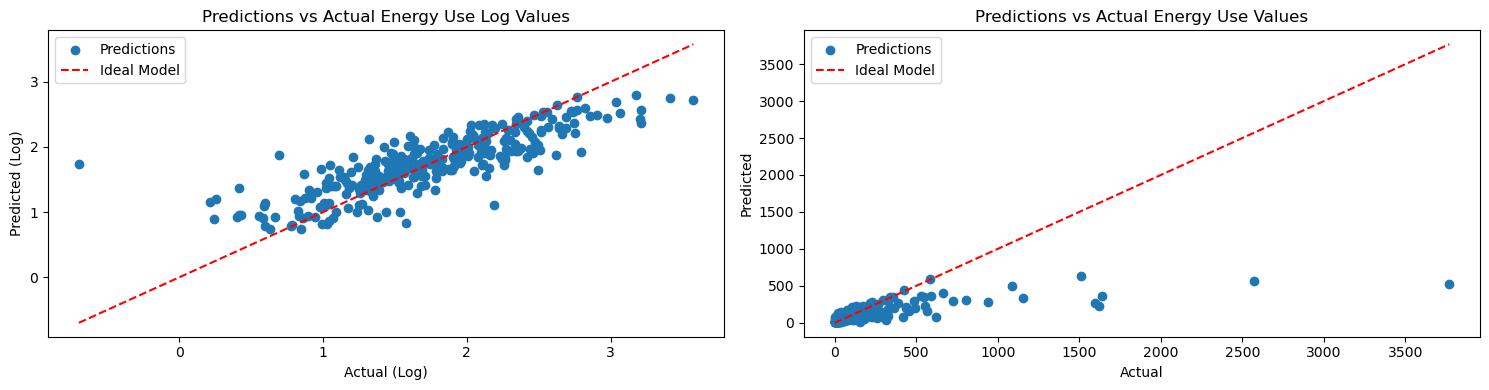

In [63]:
plot_predictions(y_test, random_forest.predict(X_test))

# EnergyStarScore

In [64]:
y = energy_data["TotalGHGEmissions"]
X_with_score = energy_data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
    ],
    axis=1,
)
X_without_score = energy_data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
        "NumberOfYearsENERGYSTARCertified",
        "ENERGYSTARScore",
    ],
    axis=1,
)

(
    X_train_wo_score,
    X_test_wo_score,
    y_train_wo_score,
    y_test_wo_score,
) = split(X_without_score, y)

(
    X_train_with_score,
    X_test_with_score,
    y_train_with_score,
    y_test_with_score,
) = split(X_with_score, y)

In [65]:
random_forest = build_pipeline(
    RandomForestRegressor(
        criterion="friedman_mse",
        max_features=1.0,
        n_estimators=50,
        random_state=42,
        min_samples_split=6,
    )
)

random_forest.fit(X_train_wo_score, y_train_wo_score)
random_forest.score(X_test_wo_score, y_test_wo_score)

0.7979001445810279

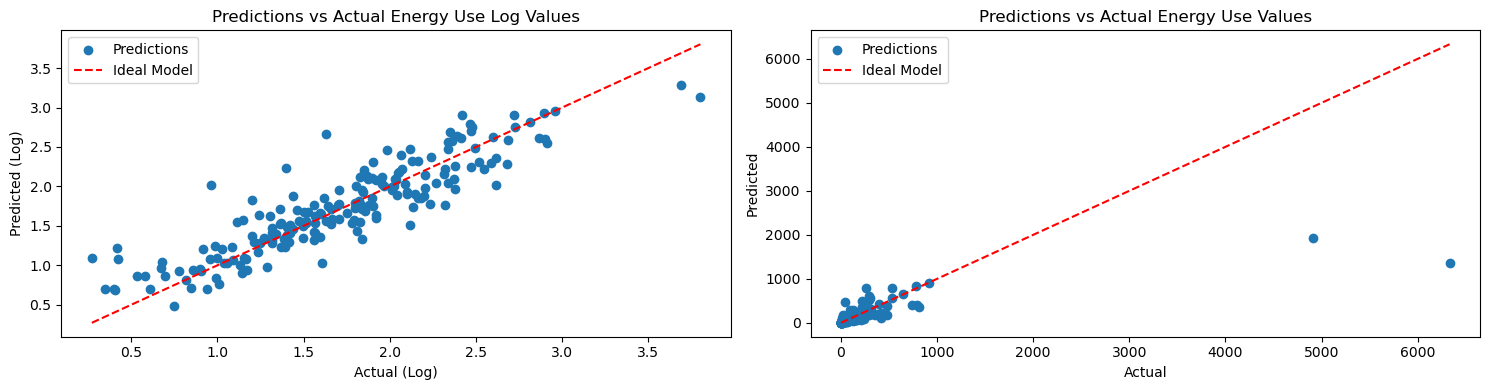

In [66]:
plot_predictions(y_test_wo_score, random_forest.predict(X_test_wo_score))

We can now compare it with the score of the model with the EnergyStarScore information

In [67]:
random_forest = build_pipeline(
    RandomForestRegressor(
        criterion="friedman_mse",
        max_features=1.0,
        n_estimators=50,
        random_state=42,
        min_samples_split=6,
    )
)

random_forest.fit(X_train_with_score, y_train_with_score)
random_forest.score(X_test_with_score, y_test_with_score)

0.8428344226913757

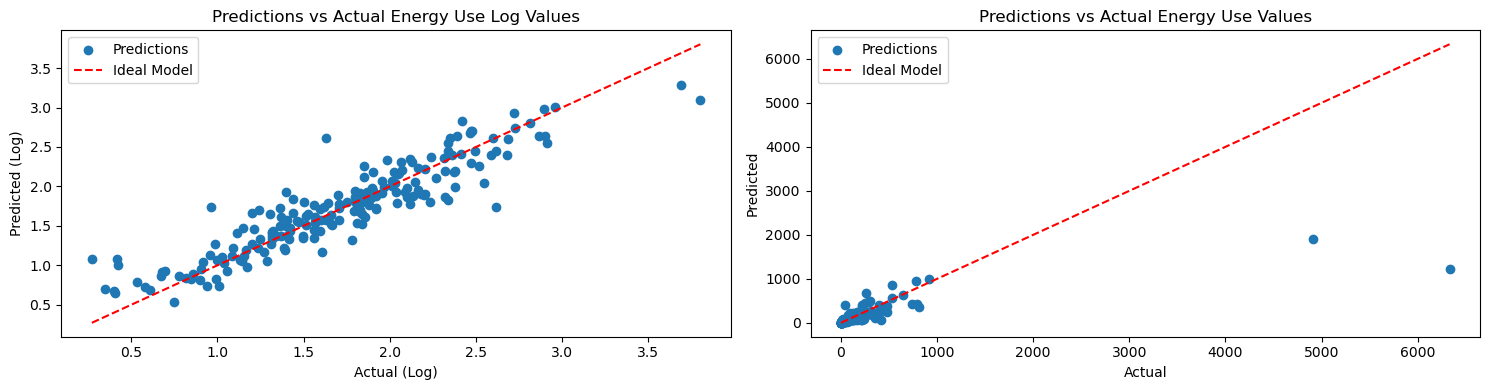

In [68]:
plot_predictions(y_test_with_score, random_forest.predict(X_test_with_score))